In [1]:
import pandas as pd
import yaml
import sys
import os
from glob import glob
from pathlib import Path
import gc
import pickle
import joblib

import warnings
warnings.filterwarnings('ignore')

sys.path.append('/kaggle/src')
from utils.lgb import fit_lgb
from utils.metric import compute_comptetition_metric
from utils.set_seed import seed_base
from feature_engineering.fe_xgb import generate_features

MODEL_NAME = "lgb_model"
PACKAGE_DIR = Path("/kaggle/src")
CFG = yaml.safe_load(open(PACKAGE_DIR / "config.yaml", "r"))
print(CFG[MODEL_NAME]["execution"]["exp_id"])

CFG["output_dir"] = f"/kaggle/output/{CFG[MODEL_NAME]['execution']['exp_id']}"
!rm -r {CFG["output_dir"]}
os.makedirs(CFG["output_dir"], exist_ok=True)

seed_base(CFG["env"]["seed"])

2023-11-13 03:54:31.683374: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-13 03:54:34.510885: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-13 03:54:43.741719: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda/lib:/usr/local/lib/x86_64-linux-gnu:/usr/local/nvidia/lib:/u

exp_136
rm: cannot remove '/kaggle/output/exp_136': No such file or directory


In [2]:
# 特徴生成
files = glob(f"{CFG['dataset']['step_csv_dir']}/*.parquet")
train, features = generate_features(files)

# cv splitとマージ
cv_split = pd.read_csv(CFG['dataset']['cv_split_path'])
train["fold"] = train["series_id"].map(cv_split.set_index("series_id")["fold"])
display(train.head(5))
train.shape

generate features: 100%|██████████| 277/277 [05:04<00:00,  1.10s/it]


,anglez,anglez_diff_abs,anglez_diff_abs_clip5,anglez_mean,enmo,enmo_diff_abs,enmo_mean,minutes,same_count,total_seconds,...,enmo_std_rolling_median_100_shift_1000,anglez_diff_abs_clip5_std_rolling_median_100_shift_1000,same_count_rolling_median_100_shift_1000,enmo_rolling_square_mean_100_shift_1000,anglez_diff_abs_clip5_rolling_square_mean_100_shift_1000,enmo_std_rolling_square_mean_100_shift_1000,anglez_diff_abs_clip5_std_rolling_square_mean_100_shift_1000,same_count_rolling_square_mean_100_shift_1000,reduce_step,fold
27,-88.181526,0.078712,0.078712,-12.090329,0.029175,0.000292,0.030480,597.5,0.0,47397.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,659,3
28,-88.507393,0.106242,0.106242,-7.547437,0.029108,0.000433,0.051443,717.5,0.0,47517.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,683,3
29,-89.259064,0.057546,0.057546,-10.070161,0.029858,0.000262,0.104063,837.5,0.0,47637.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,707,3
30,-87.457848,0.147454,0.147454,-0.726222,0.029458,0.000533,0.095024,957.5,0.0,47757.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,731,3
31,-86.225922,0.169739,0.169739,-5.723403,0.030287,0.001758,0.092043,1077.5,0.0,47877.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,755,3


(471955, 1627)

In [3]:
# 学習
dfs = []
for event in ["wakeup", "onset"]:
    trn_oof, models = fit_lgb(
        X=train, 
        y=train[f"{event}_target"], 
        folds=train["fold"].astype(int), 
        features=features.all_features(),
        params=CFG[MODEL_NAME]["lightgbm"], 
        es_rounds=100,
    )
    train["score"] = trn_oof
    train["event"] = event
    dfs.append(train[["series_id", "step", "score", "event"]])

    # 保存
    for i, model in enumerate(models):
        joblib.dump(model, os.path.join(CFG["output_dir"], f'lgb_{event}_fold_{i}.pkl'))
del train
gc.collect()
train = pd.concat(dfs, axis=0)
train["step"] = train["step"].astype(int)
train = train.sort_values(["series_id", "step"]).reset_index(drop=True)

with open(os.path.join(CFG["output_dir"], "features.pkl"), "wb") as f:
    pickle.dump(features, f)
train.to_csv(os.path.join(CFG["output_dir"], "oof.csv"), index=False)

  0%|          | 0/5 [00:00<?, ?it/s]

== fold 0 ==
[100]	valid_0's rmse: 1.11014	valid_0's l2: 1.23241
[200]	valid_0's rmse: 1.00239	valid_0's l2: 1.00478
[300]	valid_0's rmse: 0.977229	valid_0's l2: 0.954977
[400]	valid_0's rmse: 0.97075	valid_0's l2: 0.942356
[500]	valid_0's rmse: 0.968267	valid_0's l2: 0.937541
[600]	valid_0's rmse: 0.967211	valid_0's l2: 0.935496
[700]	valid_0's rmse: 0.966669	valid_0's l2: 0.934449
[800]	valid_0's rmse: 0.966392	valid_0's l2: 0.933914
[900]	valid_0's rmse: 0.966296	valid_0's l2: 0.933727
[1000]	valid_0's rmse: 0.966157	valid_0's l2: 0.933459
[1100]	valid_0's rmse: 0.965973	valid_0's l2: 0.933103
[1200]	valid_0's rmse: 0.965945	valid_0's l2: 0.933049
[1300]	valid_0's rmse: 0.965768	valid_0's l2: 0.932709
[1400]	valid_0's rmse: 0.965562	valid_0's l2: 0.93231
[1500]	valid_0's rmse: 0.965556	valid_0's l2: 0.932299
[1600]	valid_0's rmse: 0.965446	valid_0's l2: 0.932086
[1700]	valid_0's rmse: 0.965309	valid_0's l2: 0.931822
[1800]	valid_0's rmse: 0.965246	valid_0's l2: 0.9317
[1900]	valid_0

 20%|██        | 1/5 [05:27<21:48, 327.09s/it]

== fold 1 ==
[100]	valid_0's rmse: 1.12251	valid_0's l2: 1.26002
[200]	valid_0's rmse: 1.02175	valid_0's l2: 1.04397
[300]	valid_0's rmse: 0.996048	valid_0's l2: 0.992111
[400]	valid_0's rmse: 0.98836	valid_0's l2: 0.976856
[500]	valid_0's rmse: 0.985188	valid_0's l2: 0.970596
[600]	valid_0's rmse: 0.983594	valid_0's l2: 0.967456
[700]	valid_0's rmse: 0.982682	valid_0's l2: 0.965663
[800]	valid_0's rmse: 0.981998	valid_0's l2: 0.964321
[900]	valid_0's rmse: 0.981558	valid_0's l2: 0.963456
[1000]	valid_0's rmse: 0.981215	valid_0's l2: 0.962784
[1100]	valid_0's rmse: 0.980966	valid_0's l2: 0.962294
[1200]	valid_0's rmse: 0.980852	valid_0's l2: 0.96207
[1300]	valid_0's rmse: 0.98066	valid_0's l2: 0.961695
[1400]	valid_0's rmse: 0.980525	valid_0's l2: 0.96143
[1500]	valid_0's rmse: 0.980306	valid_0's l2: 0.960999
[1600]	valid_0's rmse: 0.980025	valid_0's l2: 0.960449
[1700]	valid_0's rmse: 0.97971	valid_0's l2: 0.959832
[1800]	valid_0's rmse: 0.979454	valid_0's l2: 0.95933
[1900]	valid_0's

 40%|████      | 2/5 [09:17<13:31, 270.42s/it]

== fold 2 ==
[100]	valid_0's rmse: 1.18939	valid_0's l2: 1.41465
[200]	valid_0's rmse: 1.09131	valid_0's l2: 1.19096
[300]	valid_0's rmse: 1.06519	valid_0's l2: 1.13462
[400]	valid_0's rmse: 1.05791	valid_0's l2: 1.11918
[500]	valid_0's rmse: 1.05512	valid_0's l2: 1.11328
[600]	valid_0's rmse: 1.05391	valid_0's l2: 1.11073
[700]	valid_0's rmse: 1.05327	valid_0's l2: 1.10938
[800]	valid_0's rmse: 1.05279	valid_0's l2: 1.10837
[900]	valid_0's rmse: 1.0522	valid_0's l2: 1.10713
[1000]	valid_0's rmse: 1.05183	valid_0's l2: 1.10634
[1100]	valid_0's rmse: 1.05153	valid_0's l2: 1.10571
[1200]	valid_0's rmse: 1.05132	valid_0's l2: 1.10527
[1300]	valid_0's rmse: 1.05114	valid_0's l2: 1.10489
[1400]	valid_0's rmse: 1.05102	valid_0's l2: 1.10464
[1500]	valid_0's rmse: 1.05091	valid_0's l2: 1.10442
[1600]	valid_0's rmse: 1.05078	valid_0's l2: 1.10413
[1700]	valid_0's rmse: 1.05055	valid_0's l2: 1.10366
[1800]	valid_0's rmse: 1.05051	valid_0's l2: 1.10358


 60%|██████    | 3/5 [11:34<06:58, 209.25s/it]

== fold 3 ==
[100]	valid_0's rmse: 1.13988	valid_0's l2: 1.29932
[200]	valid_0's rmse: 1.03714	valid_0's l2: 1.07567
[300]	valid_0's rmse: 1.0133	valid_0's l2: 1.02678
[400]	valid_0's rmse: 1.00733	valid_0's l2: 1.01472
[500]	valid_0's rmse: 1.00536	valid_0's l2: 1.01075
[600]	valid_0's rmse: 1.0043	valid_0's l2: 1.00861
[700]	valid_0's rmse: 1.00363	valid_0's l2: 1.00728
[800]	valid_0's rmse: 1.0027	valid_0's l2: 1.0054
[900]	valid_0's rmse: 1.00206	valid_0's l2: 1.00413
[1000]	valid_0's rmse: 1.00141	valid_0's l2: 1.00282
[1100]	valid_0's rmse: 1.001	valid_0's l2: 1.002
[1200]	valid_0's rmse: 1.00073	valid_0's l2: 1.00146
[1300]	valid_0's rmse: 1.00063	valid_0's l2: 1.00125
[1400]	valid_0's rmse: 1.00048	valid_0's l2: 1.00096
[1500]	valid_0's rmse: 0.999996	valid_0's l2: 0.999991
[1600]	valid_0's rmse: 0.999593	valid_0's l2: 0.999186
[1700]	valid_0's rmse: 0.999405	valid_0's l2: 0.998811
[1800]	valid_0's rmse: 0.999115	valid_0's l2: 0.99823
[1900]	valid_0's rmse: 0.99889	valid_0's l2

 80%|████████  | 4/5 [14:42<03:21, 201.03s/it]

== fold 4 ==
[100]	valid_0's rmse: 1.16494	valid_0's l2: 1.35708
[200]	valid_0's rmse: 1.0666	valid_0's l2: 1.13763
[300]	valid_0's rmse: 1.04208	valid_0's l2: 1.08593
[400]	valid_0's rmse: 1.0364	valid_0's l2: 1.07413
[500]	valid_0's rmse: 1.03447	valid_0's l2: 1.07014
[600]	valid_0's rmse: 1.03332	valid_0's l2: 1.06776
[700]	valid_0's rmse: 1.03304	valid_0's l2: 1.06716
[800]	valid_0's rmse: 1.03273	valid_0's l2: 1.06652
[900]	valid_0's rmse: 1.03262	valid_0's l2: 1.06629
[1000]	valid_0's rmse: 1.03244	valid_0's l2: 1.06594
[1100]	valid_0's rmse: 1.03214	valid_0's l2: 1.06531
[1200]	valid_0's rmse: 1.03206	valid_0's l2: 1.06515


  0%|          | 0/5 [00:00<?, ?it/s]

== fold 0 ==
[100]	valid_0's rmse: 1.0984	valid_0's l2: 1.20649
[200]	valid_0's rmse: 0.990536	valid_0's l2: 0.981161
[300]	valid_0's rmse: 0.96403	valid_0's l2: 0.929354
[400]	valid_0's rmse: 0.956433	valid_0's l2: 0.914765
[500]	valid_0's rmse: 0.954418	valid_0's l2: 0.910913
[600]	valid_0's rmse: 0.953829	valid_0's l2: 0.90979
[700]	valid_0's rmse: 0.953443	valid_0's l2: 0.909054
[800]	valid_0's rmse: 0.953307	valid_0's l2: 0.908795
[900]	valid_0's rmse: 0.953235	valid_0's l2: 0.908658
[1000]	valid_0's rmse: 0.953235	valid_0's l2: 0.908656
[1100]	valid_0's rmse: 0.953035	valid_0's l2: 0.908275
[1200]	valid_0's rmse: 0.95303	valid_0's l2: 0.908266
[1300]	valid_0's rmse: 0.952941	valid_0's l2: 0.908097
[1400]	valid_0's rmse: 0.952824	valid_0's l2: 0.907873
[1500]	valid_0's rmse: 0.952603	valid_0's l2: 0.907452
[1600]	valid_0's rmse: 0.95251	valid_0's l2: 0.907275
[1700]	valid_0's rmse: 0.952421	valid_0's l2: 0.907106
[1800]	valid_0's rmse: 0.952335	valid_0's l2: 0.906942


 20%|██        | 1/5 [02:25<09:41, 145.35s/it]

== fold 1 ==
[100]	valid_0's rmse: 1.08955	valid_0's l2: 1.18713
[200]	valid_0's rmse: 0.978122	valid_0's l2: 0.956723
[300]	valid_0's rmse: 0.948565	valid_0's l2: 0.899775
[400]	valid_0's rmse: 0.937579	valid_0's l2: 0.879055
[500]	valid_0's rmse: 0.933595	valid_0's l2: 0.8716
[600]	valid_0's rmse: 0.932124	valid_0's l2: 0.868856
[700]	valid_0's rmse: 0.931313	valid_0's l2: 0.867343
[800]	valid_0's rmse: 0.930962	valid_0's l2: 0.86669
[900]	valid_0's rmse: 0.930628	valid_0's l2: 0.866069
[1000]	valid_0's rmse: 0.930348	valid_0's l2: 0.865548
[1100]	valid_0's rmse: 0.930152	valid_0's l2: 0.865183
[1200]	valid_0's rmse: 0.929961	valid_0's l2: 0.864827
[1300]	valid_0's rmse: 0.9298	valid_0's l2: 0.864528
[1400]	valid_0's rmse: 0.92956	valid_0's l2: 0.864081
[1500]	valid_0's rmse: 0.929371	valid_0's l2: 0.86373
[1600]	valid_0's rmse: 0.929346	valid_0's l2: 0.863684
[1700]	valid_0's rmse: 0.929374	valid_0's l2: 0.863735


 40%|████      | 2/5 [04:48<07:12, 144.24s/it]

== fold 2 ==
[100]	valid_0's rmse: 1.17922	valid_0's l2: 1.39056
[200]	valid_0's rmse: 1.07347	valid_0's l2: 1.15234
[300]	valid_0's rmse: 1.0468	valid_0's l2: 1.09579
[400]	valid_0's rmse: 1.03833	valid_0's l2: 1.07814
[500]	valid_0's rmse: 1.03543	valid_0's l2: 1.07212
[600]	valid_0's rmse: 1.03373	valid_0's l2: 1.0686
[700]	valid_0's rmse: 1.0328	valid_0's l2: 1.06667
[800]	valid_0's rmse: 1.03223	valid_0's l2: 1.0655
[900]	valid_0's rmse: 1.03195	valid_0's l2: 1.06492
[1000]	valid_0's rmse: 1.03171	valid_0's l2: 1.06442
[1100]	valid_0's rmse: 1.03137	valid_0's l2: 1.06373
[1200]	valid_0's rmse: 1.03111	valid_0's l2: 1.06319
[1300]	valid_0's rmse: 1.0309	valid_0's l2: 1.06275
[1400]	valid_0's rmse: 1.03069	valid_0's l2: 1.06233
[1500]	valid_0's rmse: 1.03057	valid_0's l2: 1.06208
[1600]	valid_0's rmse: 1.03034	valid_0's l2: 1.06159
[1700]	valid_0's rmse: 1.03023	valid_0's l2: 1.06138
[1800]	valid_0's rmse: 1.03013	valid_0's l2: 1.06116


 60%|██████    | 3/5 [07:31<05:05, 152.64s/it]

== fold 3 ==
[100]	valid_0's rmse: 1.143	valid_0's l2: 1.30644
[200]	valid_0's rmse: 1.053	valid_0's l2: 1.10882
[300]	valid_0's rmse: 1.03466	valid_0's l2: 1.07053
[400]	valid_0's rmse: 1.02957	valid_0's l2: 1.06001
[500]	valid_0's rmse: 1.02788	valid_0's l2: 1.05653
[600]	valid_0's rmse: 1.02751	valid_0's l2: 1.05577
[700]	valid_0's rmse: 1.02725	valid_0's l2: 1.05525
[800]	valid_0's rmse: 1.02709	valid_0's l2: 1.05491
[900]	valid_0's rmse: 1.02711	valid_0's l2: 1.05496


 80%|████████  | 4/5 [09:13<02:12, 132.81s/it]

== fold 4 ==
[100]	valid_0's rmse: 1.16966	valid_0's l2: 1.36811
[200]	valid_0's rmse: 1.07537	valid_0's l2: 1.15643
[300]	valid_0's rmse: 1.05199	valid_0's l2: 1.10667
[400]	valid_0's rmse: 1.04501	valid_0's l2: 1.09205
[500]	valid_0's rmse: 1.04305	valid_0's l2: 1.08796
[600]	valid_0's rmse: 1.04233	valid_0's l2: 1.08646
[700]	valid_0's rmse: 1.04183	valid_0's l2: 1.08541
[800]	valid_0's rmse: 1.04141	valid_0's l2: 1.08453
[900]	valid_0's rmse: 1.04092	valid_0's l2: 1.08352
[1000]	valid_0's rmse: 1.04061	valid_0's l2: 1.08288
[1100]	valid_0's rmse: 1.04035	valid_0's l2: 1.08232
[1200]	valid_0's rmse: 1.04012	valid_0's l2: 1.08186
[1300]	valid_0's rmse: 1.03991	valid_0's l2: 1.08141
[1400]	valid_0's rmse: 1.03976	valid_0's l2: 1.0811
[1500]	valid_0's rmse: 1.03962	valid_0's l2: 1.08081


100%|██████████| 5/5 [11:33<00:00, 138.67s/it]


## Dynamic-Range NMS

<AxesSubplot: >

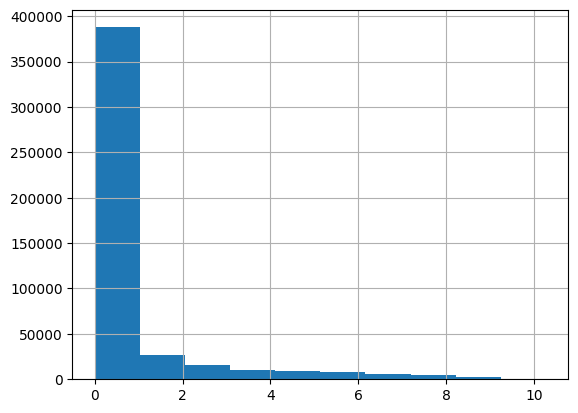

In [4]:
train = train[train["score"] > 0.005]
train["score"].hist()

In [5]:
from utils.postprocess import dynamic_range_nms
from multiprocessing import Pool
from tqdm import tqdm

train["step"] = train["step"].astype(int)

groups = [group for _, group in train.groupby("series_id")]
with Pool(30) as p:  
    results = list(tqdm(p.imap(dynamic_range_nms, groups), total=len(groups)))
sub = pd.concat(results)
sub["score"] = sub["reduced_score"]

100%|██████████| 277/277 [00:05<00:00, 51.14it/s]


In [6]:
# スコア計算
labels = pd.read_csv(f"{CFG['dataset']['competition_dir']}/train_events.csv").dropna()
score, ap_table = compute_comptetition_metric(labels, sub)

print(f"score: {score:.4f}")
display(ap_table)
sub.to_csv(os.path.join(CFG["output_dir"], "submission_after_nms.csv"), index=False)

score: 0.7866


event   tolerance
onset   12           0.256142
        36           0.698234
        60           0.792406
        90           0.835000
        120          0.850896
        150          0.865500
        180          0.873739
        240          0.887351
        300          0.893478
        360          0.898525
wakeup  12           0.210973
        36           0.715118
        60           0.800520
        90           0.836694
        120          0.855837
        150          0.868667
        180          0.879395
        240          0.894223
        300          0.904786
        360          0.915049
dtype: float64